In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [96]:
df=pd.read_csv('./INFY.csv',index_col='Date',parse_dates=True)

Data Pre processing


In [97]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,INFOSYSTCH,EQ,14467.75,15625.00,15625.20,15625.00,15625.20,15625.20,15625.18,5137,8.026657e+12,NaN,NaN,NaN
2000-01-04,INFOSYSTCH,EQ,15625.20,16800.00,16875.25,16253.00,16875.25,16855.90,16646.38,56186,9.352937e+13,NaN,NaN,NaN
2000-01-05,INFOSYSTCH,EQ,16855.90,15701.00,16250.00,15507.45,15507.45,15507.45,15786.38,164605,2.598516e+14,NaN,NaN,NaN
2000-01-06,INFOSYSTCH,EQ,15507.45,15256.65,15300.00,14266.85,14266.85,14266.85,14462.82,81997,1.185908e+14,NaN,NaN,NaN
2000-01-07,INFOSYSTCH,EQ,14266.85,13125.50,13125.50,13125.50,13125.50,13125.50,13125.50,7589,9.960942e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,INFY,EQ,1333.80,1332.25,1351.30,1321.00,1345.00,1343.55,1343.19,7088606,9.521361e+14,130375.0,4218129.0,0.5951
2021-04-27,INFY,EQ,1343.55,1346.00,1353.00,1340.15,1347.50,1348.50,1346.89,3636115,4.897445e+14,145974.0,1871084.0,0.5146
2021-04-28,INFY,EQ,1348.50,1358.00,1359.50,1344.60,1355.80,1356.00,1353.45,4879234,6.603778e+14,137376.0,2857134.0,0.5856


In [98]:
df['Date']=df.index

In [99]:
start_date='2020-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [100]:
df=df.loc[mask]

In [101]:
df=df.loc[mask]

In [102]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [103]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [104]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [105]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [106]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (201, 50) Y.shape (201,)


In [107]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

ANN

In [108]:
i=Input(shape=(T,))
x=Dense(400,activation='relu')(i)
x=Dense(100,activation='relu')(x)
x=Dense(50,activation='relu')(x)
x=Dense(1,activation='relu')(x)
model_ann=Model(i,x)
model_ann.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_14 (Dense)            (None, 400)               20400     
                                                                 
 dense_15 (Dense)            (None, 100)               40100     
                                                                 
 dense_16 (Dense)            (None, 50)                5050      
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 65,601
Trainable params: 65,601
Non-trainable params: 0
_________________________________________________________________


In [109]:
model_ann.compile(
    loss='mse',
    optimizer='adamax',
    metrics='mae'
)

In [110]:
r=model_ann.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
4/4 [==============================] - 1s 55ms/step - loss: 443.6341 - mae: 15.1568 - val_loss: 351.6618 - val_mae: 15.0829
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 391.2584 - mae: 13.7856 - val_loss: 356.9168 - val_mae: 15.2816
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 365.8217 - mae: 13.1775 - val_loss: 364.9426 - val_mae: 15.5142
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 347.6458 - mae: 13.2021 - val_loss: 369.0037 - val_mae: 15.5932
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 330.1662 - mae: 12.3933 - val_loss: 367.3170 - val_mae: 15.5067
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 318.4467 - mae: 11.8612 - val_loss: 368.0585 - val_mae: 15.5095
Epoch 7/100
4/4 [==============================] - 0s 21ms/step - loss: 308.2104 - mae: 11.4706 - val_loss: 374.5282 - val_mae: 15.6596
Epoch 8/100
4/4 [==============================]

CNN

In [111]:
i=Input(shape=(T,1))
x=Conv1D(25,3,activation='relu')(i)
x=MaxPooling1D(2)(x)
x=Conv1D(50,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(1)(x)
model_cnn=Model(i,x)
model_cnn.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 48, 25)            100       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 24, 25)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 22, 50)            3800      
                                                                 
 global_max_pooling1d_4 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 1)                 51  

In [112]:
model_cnn.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [113]:
r=model_cnn.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
4/4 [==============================] - 1s 62ms/step - loss: 670.0285 - mae: 18.8383 - mse: 670.0285 - val_loss: 362.7186 - val_mae: 14.9056 - val_mse: 362.7186
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 482.8508 - mae: 15.9633 - mse: 482.8508 - val_loss: 343.0088 - val_mae: 14.6511 - val_mse: 343.0088
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 476.5220 - mae: 16.0026 - mse: 476.5220 - val_loss: 351.4820 - val_mae: 14.8606 - val_mse: 351.4820
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 481.7859 - mae: 16.1616 - mse: 481.7859 - val_loss: 348.9081 - val_mae: 14.7679 - val_mse: 348.9081
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 466.8818 - mae: 15.7983 - mse: 466.8818 - val_loss: 343.7302 - val_mae: 14.6297 - val_mse: 343.7302
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 454.1115 - mae: 15.3434 - mse: 454.1115 - val_loss: 343.1086 - val_m

LSTM

In [114]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_lstm=Model(i,x)
model_lstm.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 200)           161600    
                                                                 
 lstm_5 (LSTM)               (None, 50, 200)           320800    
                                                                 
 global_max_pooling1d_5 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_19 (Dense)            (None, 100)               20100     
                                                                 
 dense_20 (Dense)            (None, 50)                5050      
                                                           

In [115]:
check_point_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [116]:
model_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [117]:
r=model_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm]
)

Epoch 1/100
4/4 [==============================] - 6s 720ms/step - loss: 446.3005 - mae: 14.9684 - mse: 446.3005 - val_loss: 357.4124 - val_mae: 14.9744 - val_mse: 357.4124
Epoch 2/100
4/4 [==============================] - 1s 328ms/step - loss: 441.0261 - mae: 14.8748 - mse: 441.0261 - val_loss: 347.5306 - val_mae: 14.8388 - val_mse: 347.5306
Epoch 3/100
4/4 [==============================] - 1s 323ms/step - loss: 438.5650 - mae: 14.8035 - mse: 438.5650 - val_loss: 344.2618 - val_mae: 14.7844 - val_mse: 344.2618
Epoch 4/100
4/4 [==============================] - 1s 322ms/step - loss: 437.5544 - mae: 14.7888 - mse: 437.5544 - val_loss: 343.9519 - val_mae: 14.7793 - val_mse: 343.9519
Epoch 5/100
4/4 [==============================] - 1s 332ms/step - loss: 436.9986 - mae: 14.7811 - mse: 436.9986 - val_loss: 343.8568 - val_mae: 14.7789 - val_mse: 343.8568
Epoch 6/100
4/4 [==============================] - 1s 315ms/step - loss: 436.9737 - mae: 14.7870 - mse: 436.9737 - val_loss: 344.4532 -

GRU

In [135]:
i=Input(shape=(T,1))
x=GRU(200,return_sequences=True)(i)
x=GRU(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_gru=Model(i,x)
model_gru.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fa7552616d0>>

In [136]:
check_point_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [137]:
model_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [140]:
r=model_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_gru]
)

Epoch 1/100
4/4 [==============================] - 6s 566ms/step - loss: 447.6551 - mae: 15.0462 - mse: 447.6551 - val_loss: 352.5046 - val_mae: 14.9082 - val_mse: 352.5046
Epoch 2/100
4/4 [==============================] - 1s 283ms/step - loss: 439.6837 - mae: 14.8601 - mse: 439.6837 - val_loss: 342.3377 - val_mae: 14.7402 - val_mse: 342.3377
Epoch 3/100
4/4 [==============================] - 1s 273ms/step - loss: 439.3427 - mae: 14.8864 - mse: 439.3427 - val_loss: 342.3847 - val_mae: 14.7273 - val_mse: 342.3847
Epoch 4/100
4/4 [==============================] - 1s 274ms/step - loss: 437.4954 - mae: 14.8425 - mse: 437.4954 - val_loss: 342.9583 - val_mae: 14.7619 - val_mse: 342.9583
Epoch 5/100
4/4 [==============================] - 1s 278ms/step - loss: 434.9413 - mae: 14.7752 - mse: 434.9413 - val_loss: 344.5293 - val_mae: 14.7959 - val_mse: 344.5293
Epoch 6/100
4/4 [==============================] - 1s 278ms/step - loss: 435.2366 - mae: 14.7659 - mse: 435.2366 - val_loss: 346.4960 -

Predictions

In [141]:
train_idx[:T+1]=False

In [142]:
Ptrain_ann=model_ann.predict(Xtrain).flatten()
Ptest_ann=model_ann.predict(Xtest).flatten()


In [143]:
Ptrain_cnn=model_cnn.predict(Xtrain).flatten()
Ptest_cnn=model_cnn.predict(Xtest).flatten()

In [144]:
Ptrain_lstm=model_lstm.predict(Xtrain).flatten()
Ptest_lstm=model_lstm.predict(Xtest).flatten()

In [145]:
Ptrain_gru=model_gru.predict(Xtrain).flatten()
Ptest_gru=model_gru.predict(Xtest).flatten()

In [146]:
df.loc[train_idx,'Diff ANN train prediction']=Ptrain_ann
df.loc[test_idx,'Diff ANN test prediction']=Ptest_ann

In [147]:
df.loc[train_idx,'Diff CNN train prediction']=Ptrain_cnn
df.loc[test_idx,'Diff CNN test prediction']=Ptest_cnn

In [148]:
df.loc[train_idx,'Diff LSTM train prediction']=Ptrain_lstm
df.loc[test_idx,'Diff LSTM test prediction']=Ptest_lstm

In [149]:
df.loc[train_idx,'Diff GRU train prediction']=Ptrain_gru
df.loc[test_idx,'Diff GRU test prediction']=Ptest_gru

In [150]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [151]:
last_train=train.iloc[-1]['Prev Close']

In [152]:
df.loc[train_idx,'train_ANN']=prev[train_idx]+Ptrain_ann
df.loc[test_idx,'Prediction_ANN']=prev[test_idx]+Ptest_ann

In [153]:
df.loc[train_idx,'train_CNN']=prev[train_idx]+Ptrain_cnn
df.loc[test_idx,'Prediction_CNN']=prev[test_idx]+Ptest_cnn

In [154]:
df.loc[train_idx,'train_LSTM']=prev[train_idx]+Ptrain_lstm
df.loc[test_idx,'Prediction_LSTM']=prev[test_idx]+Ptest_lstm

In [155]:
df.loc[train_idx,'train_GRU']=prev[train_idx]+Ptrain_gru
df.loc[test_idx,'Prediction_GRU']=prev[test_idx]+Ptest_gru

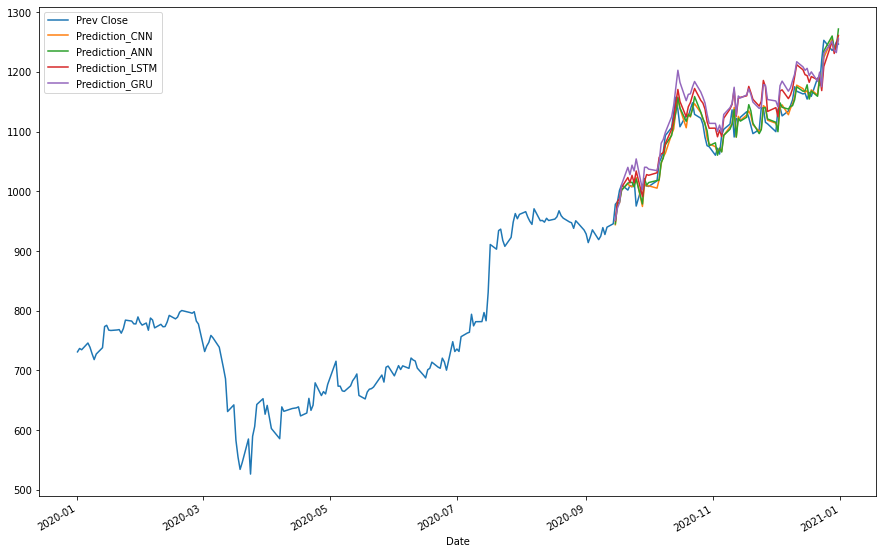

In [156]:
df[[ 'Prev Close','Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10));

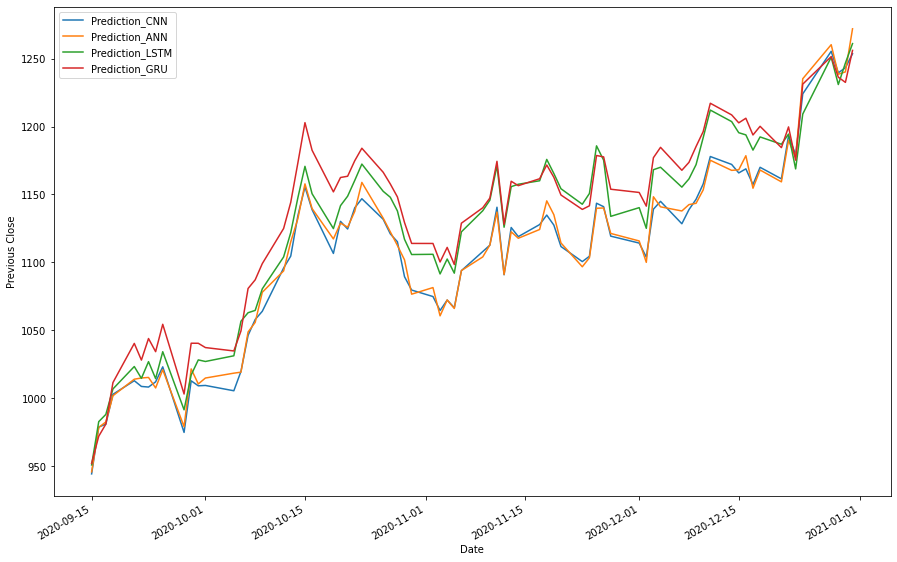

In [160]:
df[[ 'Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10),
    ylabel=("Previous Close"));

Evaluation

In [161]:
pred_ann=df['Prediction_ANN']
pred_ann.dropna(inplace=True)

In [163]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_ann))
print(rmse)

19.47815183555755


In [164]:
error=mean_absolute_error(test['Prev Close'],pred_ann)
print(error)

15.882793166577812


In [165]:
r2_score(test['Prev Close'],pred_ann)

0.9144741867946664

In [166]:
pred_cnn=df['Prediction_CNN']
pred_cnn.dropna(inplace=True)

In [168]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_cnn))
print(rmse)

18.944763132815286


In [169]:
error=mean_absolute_error(test['Prev Close'],pred_cnn)
print(error)

14.925461731463672


In [170]:
r2_score(test['Prev Close'],pred_cnn)

0.9190941215378371

In [167]:
pred_lstm=df['Prediction_LSTM']
pred_lstm.dropna(inplace=True)

In [171]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm))
print(rmse)

30.494695103421506


In [172]:
error=mean_absolute_error(test['Prev Close'],pred_lstm)
print(error)

24.989303448041284


In [173]:
r2_score(test['Prev Close'],pred_lstm)

0.7903715083553245

In [175]:
pred_gru=df['Prediction_GRU']
pred_gru.dropna(inplace=True)

In [176]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_gru))
print(rmse)

37.10440421555714


In [177]:
error=mean_absolute_error(test['Prev Close'],pred_gru)
print(error)

31.811871470053998


In [178]:
r2_score(test['Prev Close'],pred_gru)

0.6896493612920671